## This notebook extracts syllables from a segmented waveform into spectrograms
- This notebook takes WAV datasets generated by `1.0-segment-song-from-wavs` and segments generated by `2.1-Segment-syllables-make-textgrid`
  - WAVs are expected to be in this format: `2017-04-16_17-27-44-760000.wav` and TextGrids are explected to be in the format `2017-04-16_17-27-44-760000.TextGrid`
- The notebook outputs an HDF5 file which contains metadata about who the individual is, when the syllable was sung, how long the syllable is, which file the syllable comes from

### Import Packages

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from datetime import datetime
import pandas as pd
import copy
from praatio import tgio

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
import IPython.display

In [4]:
from avgn.utils.audio import load_wav, int16_to_float32
from avgn.utils.paths import DATA_DIR, ensure_dir
from avgn.utils.general import save_dict_pickle, zero_one_norm, rescale
from avgn.bout_segmentation.dynamic_threshold_segmentation import (
    dynamic_spectrogram,
    contiguous_regions,
    cut_syllables,
    boundaries_to_textgrid,
)
from avgn.visualization.spectrogram import (
    plot_segmentations,
    plot_bout_to_syllable_pipeline,
    visualize_spec
)
from avgn.signalprocessing.filtering import butter_bandpass_filter
from avgn.signalprocessing.spectrogramming import _build_mel_basis, inv_spectrogram

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


### Parameters for segmenting syllables

In [41]:
# the size of the syllables (pixels*pixels)
syll_size = 32

# parameters for filtering
filtering_params = {
    # filtering
    "highcut": 15000,
    "lowcut": 500,
}

mel_params = {
    "mel_filter": False,  # should a mel filter be used?
    "num_mels": syll_size,  # how many channels to use in the mel-spectrogram
    "fmin_mel": 300,  # low frequency cutoff for mel filter
    "fmax_mel": None,  # high frequency cutoff for mel filter
}

spectrogramming_params = {
    # spectrograms
    "num_freq": 512,  # how many channels to use in a spectrogram
    "num_freq_final": syll_size,  # how many channels to use in the resized spectrogram
    "preemphasis": 0.97,
    "min_silence_for_spec": 0.05,  # minimum length of silence for a spectrogram to be considered a good spectrogram
    "max_vocal_for_spec": 5.0,  # the longest a single vocalization (protosyllable) is allowed to be
    "frame_shift_ms": 0.5,  # step size for fft
    "frame_length_ms": 6,  # frame length for fft
    "min_level_dB": -100,  # minimum threshold db for computing spe
    "min_level_dB_floor": -20,  # (db)
    "spec_thresh_delta_dB": 5,  # (db) what
    "ref_level_dB": 20,  # reference db for computing spec
    
}

bout_threshold_params = {
    # Silence Thresholding
    "silence_threshold": 0.01,  # normalized threshold for silence
    "min_len": 5.0,  # minimum length for a vocalization (fft frames)
}

syllabification_params = {
    # Syllabification
    "min_syll_len_s": 0.03,  # minimum length for a syllable
    "min_num_sylls": 20,  # min number of syllables to be considered a bout
    "max_size_syll": syll_size,  # the size of the syllable
    "resize_samp_fr": int(
        syll_size * 10
    ),  # (frames/s) the framerate of the syllable (in compressed spectrogram time components)
}
spectrogram_inversion_params = {
    # spectrogram inversion
    "griffin_lim_iters": 60,
    "power": 1.5,
    # Thresholding out noise
    "mel_noise_filt": 0.15,  # thresholds out low power noise in the spectrum - higher numbers will diminish inversion quality
}

hparams = {}

for d in [
    filtering_params,
    spectrogramming_params,
    bout_threshold_params,
    syllabification_params,
    spectrogram_inversion_params,
    mel_params
]:
    for k, v in d.items():
        hparams[k] = v

In [42]:
# this is used to identify this training instance
now_string = datetime.now().strftime(
    "%Y-%m-%d_%H-%M-%S"
)  
# save the dictionary so that we can reload it for recovering waveforms
dict_save = DATA_DIR / ("parameter_dictionaries/" + now_string + "_dict.pickle")
ensure_dir(dict_save)
save_dict_pickle(hparams, dict_save)
print(dict_save)

/mnt/cube/tsainbur/Projects/github_repos/AVGN_419/AVGN/data/parameter_dictionaries/2019-04-30_14-16-25_dict.pickle


### read WAV data

In [43]:
wav_loc = DATA_DIR / 'BF/Koumura_Okanoya/bouts/Bird2/wavs/1900-03-14_13-00-00-000000.wav'
wav_loc

PosixPath('/mnt/cube/tsainbur/Projects/github_repos/AVGN_419/AVGN/data/BF/Koumura_Okanoya/bouts/Bird2/wavs/1900-03-14_13-00-00-000000.wav')

In [44]:
# read in the data
csv_loc = wav_loc.parents[1]/'csv'/(wav_loc.stem + '.csv')
rate, data = load_wav(wav_loc)

In [45]:
hparams["sample_rate"] = rate

In [46]:
(bird, original_wav, start_time) = pd.read_csv(csv_loc, header=None).values[0]
start_time = datetime.strptime(start_time, "%Y-%m-%d_%H-%M-%S-%f")

In [47]:
# load textgrid
textgrid_loc = wav_loc.parents[1]/'TextGrids'/(wav_loc.stem + '.TextGrid')
textgrid = tgio.openTextgrid(fnFullPath=textgrid_loc)
textgrid.tierDict['syllables'].entryList[:3]

[Interval(start=0.527, end=0.5810000000000001, label='syll'),
 Interval(start=0.5865, end=0.6175, label='syll'),
 Interval(start=0.648, end=0.7075, label='syll')]

In [48]:
# bandpass filter data
data = butter_bandpass_filter(data, hparams['lowcut'], hparams['highcut'], rate, order=2).astype('float32')

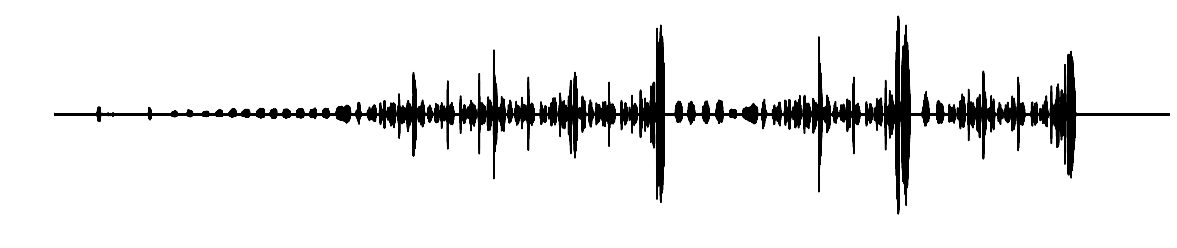

In [49]:
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(20,4))
plt.plot(data, color='black')
ax.set_xlim((0, len(data)))
ax.axis('off')
plt.show()

In [50]:
# play back a sample of the song
IPython.display.Audio(data=data[:rate*10], rate=44100)

### Compute the spectrogram

In [51]:
# build a basis function if you are using a mel spectrogram
_mel_basis = _build_mel_basis(hparams) 

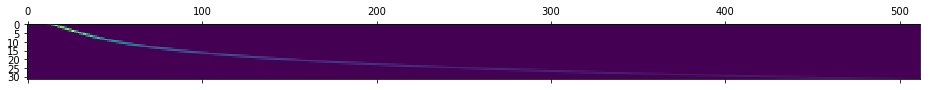

In [52]:
plt.matshow(_mel_basis)

In [53]:
# Generates the spectrogram and also thresholds out bad spectrograms (e.g. too noisy) - take a look at wav_to_syllables.py to determine if you want this
spec, vocal_envelope, cur_spec_thresh, fft_rate = dynamic_spectrogram(data/np.max(np.abs(data)), _mel_basis = _mel_basis, hparams=hparams, verbose=True)

longest silence 0.016
longest vocalization 0.349
Current min_level_dB: -95
longest silence 0.016
longest vocalization 0.349
Current min_level_dB: -90
longest silence 0.017
longest vocalization 0.349
Current min_level_dB: -85
longest silence 0.017
longest vocalization 0.349
Current min_level_dB: -80
longest silence 0.017
longest vocalization 0.342
Current min_level_dB: -75
longest silence 0.0185
longest vocalization 0.2695
Current min_level_dB: -70


/mnt/cube/tsainbur/Projects/github_repos/AVGN_419/AVGN/avgn/bout_segmentation/dynamic_threshold_segmentation.py:94: RuntimeWarning: invalid value encountered in sqrt
  vocal_envelope = np.max(spec, axis=0) * np.sqrt(np.mean(spec, axis=0))


longest silence 0.034
longest vocalization 0.2695
Current min_level_dB: -65
longest silence 0.046
longest vocalization 0.2695
Current min_level_dB: -60
longest silence 0.1995
longest vocalization 0.21


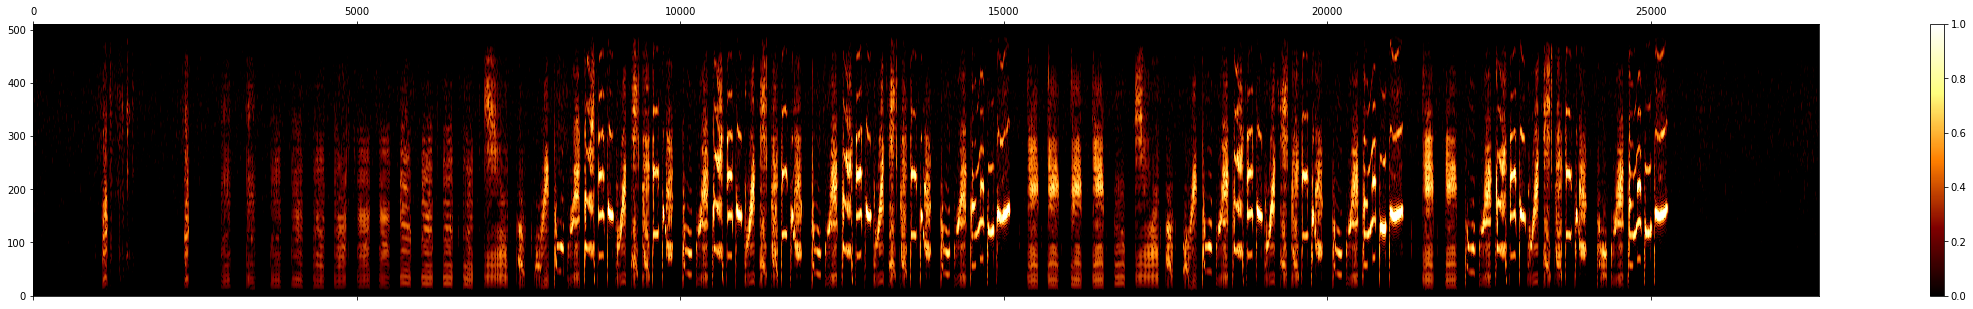

In [54]:
visualize_spec(spec, figsize=(40,5))

### Segment syllables from textgrid

In [55]:
textgrid.tierDict['syllables'].entryList[:3]

[Interval(start=0.527, end=0.5810000000000001, label='syll'),
 Interval(start=0.5865, end=0.6175, label='syll'),
 Interval(start=0.648, end=0.7075, label='syll')]

In [56]:
tier = textgrid.tierDict['syllables'].entryList

In [57]:
all_syllables = [spec[:,int(interval.start*fft_rate):int(interval.end*fft_rate)] for interval in tier]

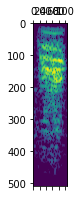

In [58]:
fig, ax = plt.subplots(figsize=(3,3))
ax.matshow(all_syllables[0])

### resize and pad spectrograms

In [59]:
from avgn.bout_segmentation.create_syllables_dataset import resize_syllables, thresh_mode, pad_spectrogram

In [60]:
# resize syllables
all_syllables_resized = resize_syllables(all_syllables, fft_rate, hparams)

In [61]:
# set mode to 0
all_syllables_resized = [thresh_mode(syll) for syll in all_syllables_resized]

In [62]:
# 0 pad syllables
all_syllables_comp = np.array(
    [pad_spectrogram(i, hparams["max_size_syll"]) for i in all_syllables_resized]
)

In [63]:
# convert to 8 bit
all_syllables_comp = [(zero_one_norm(i)*255).astype('uint8') for i in all_syllables_comp]

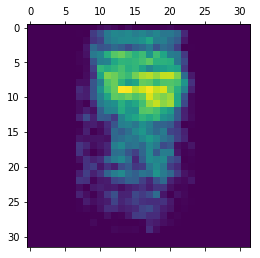

In [64]:
plt.matshow(all_syllables_comp[0])

### Plot final output

In [65]:
from avgn.visualization.spectrogram import plot_syllable_list, plot_segmentations, plot_bout_to_syllable_pipeline

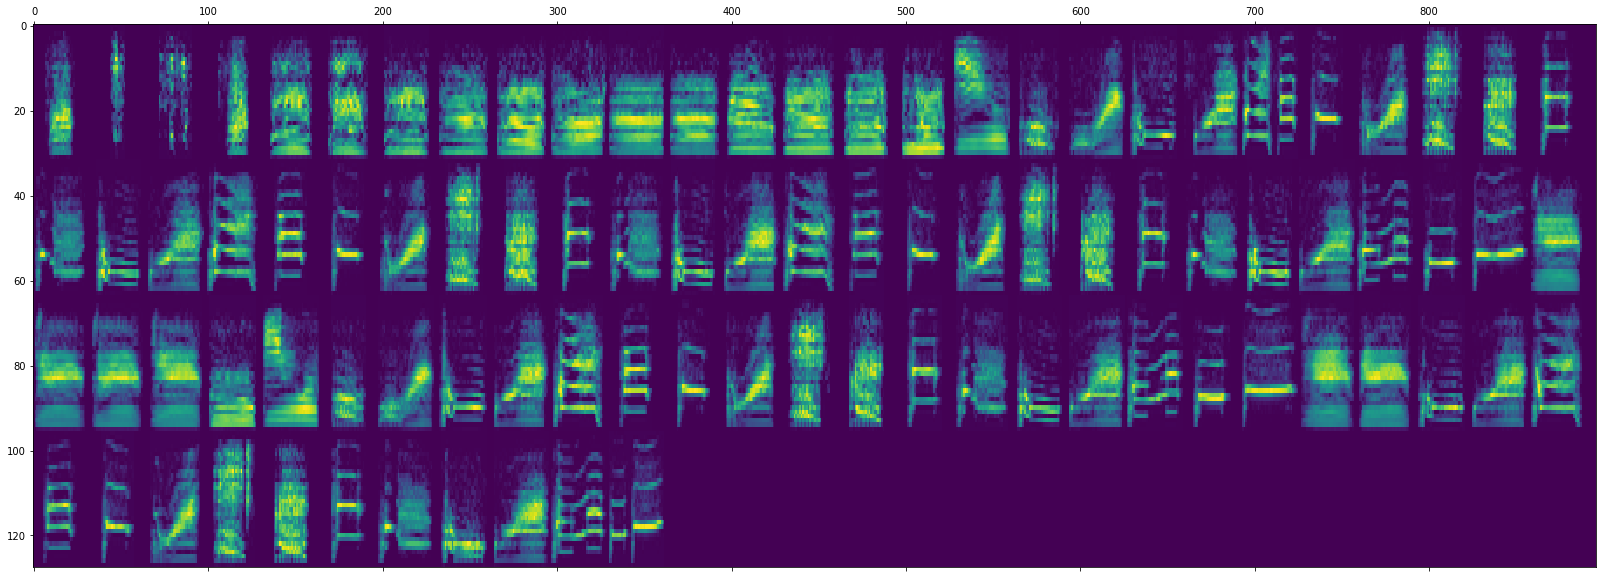

In [66]:
plot_syllable_list(all_syllables_comp, hparams["num_freq_final"], max_rows=10, width=128*7)

In [67]:
syll_onsets = [interval.start for interval in tier]
syll_lens = [interval.end- interval.start for interval in tier]

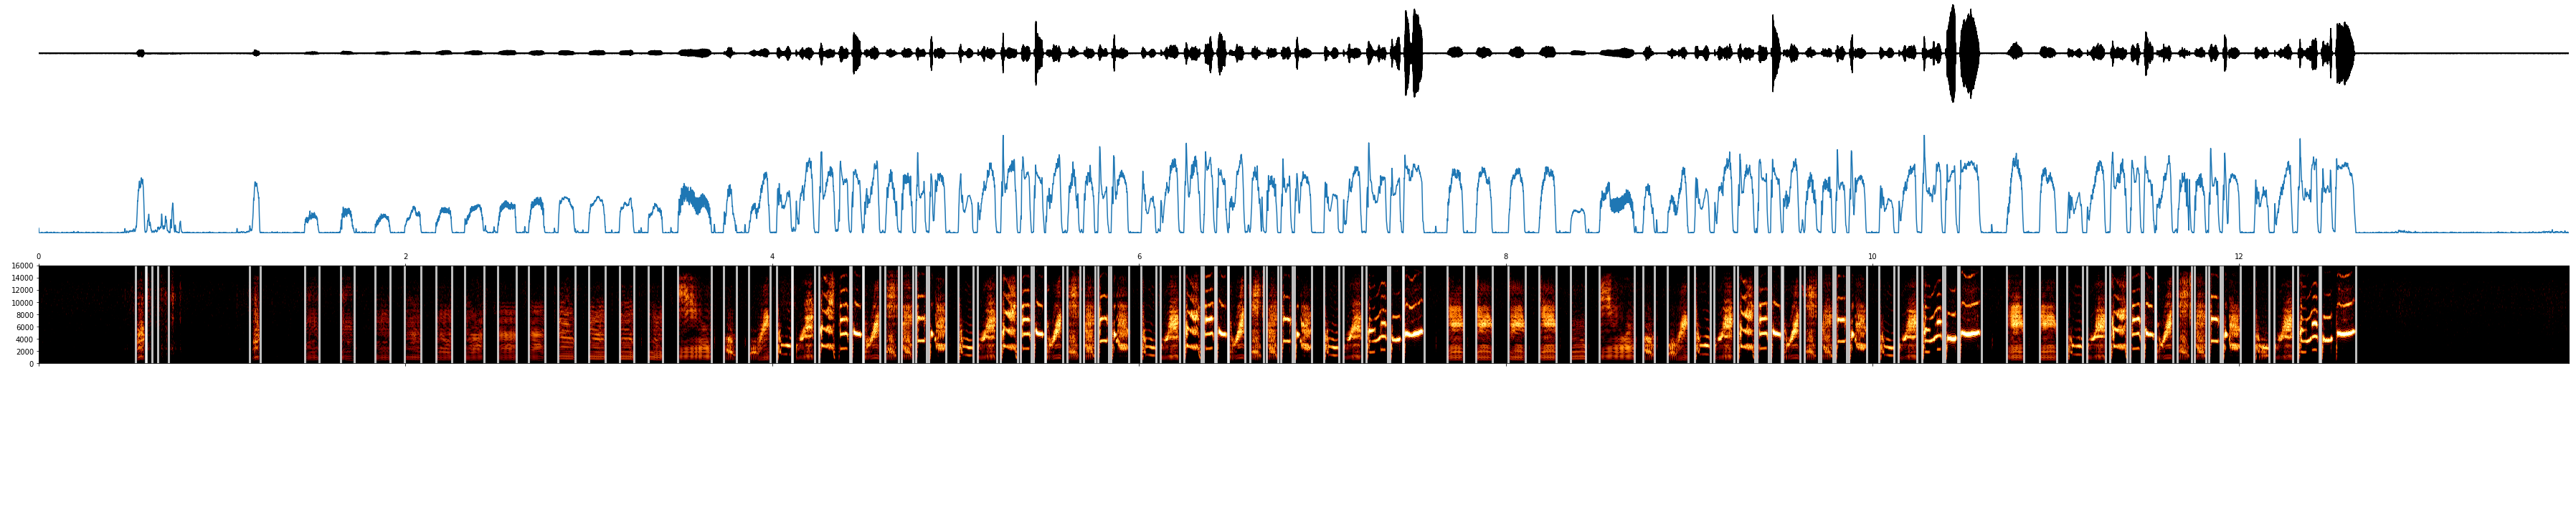

In [68]:
plot_bout_to_syllable_pipeline(data, vocal_envelope, spec,  all_syllables, syll_onsets, syll_lens, rate, fft_rate)

## Test spectral reconstruction on syllable

#### Reconstruction on syllables that have not been compressed in time

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


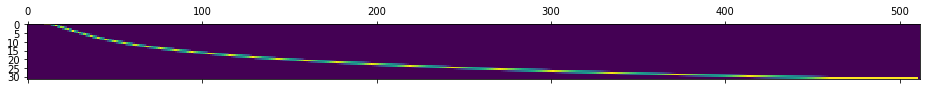

In [69]:
# create the mel inversion filter
mel_inversion_filter = (_mel_basis.T / _mel_basis.sum(axis=1))
mel_inversion_filter =np.nan_to_num(np.transpose(mel_inversion_filter / mel_inversion_filter.sum(axis=1)[:, np.newaxis]))
plt.matshow(mel_inversion_filter)

#### Test spectral reconstruction on syllable

In [70]:
from avgn.bout_segmentation.create_syllables_dataset import resize_compressed_syllable

In [71]:
len(all_syllables_comp)

92

In [72]:
# set the min_level_dB to something more reasonable
hparams['min_level_dB'] = cur_spec_thresh
hparams['griffin_lim_iters'] = 200
hparams['power'] = 1.0

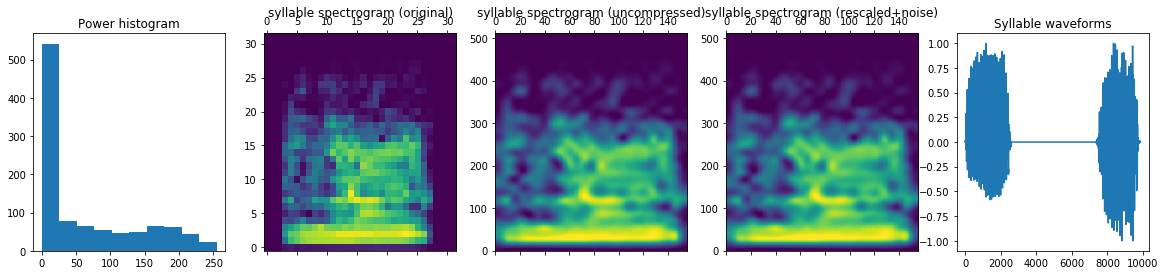

In [73]:
noise = 0.001
syll_num = 15
# get syllable
syll = all_syllables_comp[syll_num]
# reshape/convolve with filter
syll_resized = resize_compressed_syllable(syll, hparams, mel_inversion_filter)
### adding some noise tends to improve reconstruction quality
syll_scaled = rescale(syll_resized, 0, 1) + np.reshape(
    np.random.rand(np.prod(np.shape(syll_resized))) * noise, np.shape(syll_resized)
)
# test spectrogram inversion
waveform_reconstructed = inv_spectrogram(syll_scaled, hparams)
# grab the original waveform
waveform_original = data[
    int(syll_onsets[syll_num] * rate) : int(
    (syll_onsets[syll_num] + syll_lens[syll_num]) * rate
    )
]
# join the two
joined_wavs = np.concatenate([(waveform_original/np.max(waveform_original)), np.zeros(int(rate*.15)), (waveform_reconstructed/waveform_reconstructed.max())])

# viz
fig, ax = plt.subplots(nrows=1,ncols=5, figsize=(20,4))
_ = ax[0].hist(syll.flatten())
ax[0].set_title('Power histogram')
ax[1].matshow(zero_one_norm(syll.astype('float32')), origin='lower', aspect='auto')
ax[1].set_title('syllable spectrogram (original)')
ax[2].matshow(zero_one_norm(syll_resized.astype('float32')), origin='lower', aspect='auto')
ax[2].set_title('syllable spectrogram (uncompressed)')
ax[3].matshow(zero_one_norm(syll_scaled.astype('float32')), origin='lower', aspect='auto')
ax[3].set_title('syllable spectrogram (rescaled+noise)')
ax[4].plot(joined_wavs)
ax[4].set_title('Syllable waveforms')
plt.show()

IPython.display.Audio(
    data=joined_wavs,
    rate=rate,
)

### Compare spectrogram of recovered syllable

In [74]:
from avgn.signalprocessing.spectrogramming import spectrogram

In [75]:
original_spec = spectrogram(zero_one_norm(waveform_original), hparams)
reconstructed_spec = spectrogram((waveform_reconstructed), hparams)

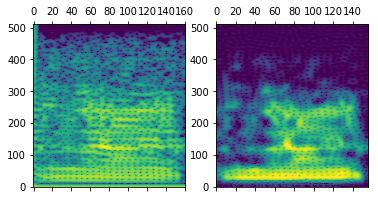

In [76]:
fig, ax = plt.subplots(ncols= 2, figsize=(6,3))
ax[0].matshow(original_spec, origin='lower', aspect='auto')
ax[1].matshow(reconstructed_spec, origin='lower', aspect='auto')